In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (10,6)

In [67]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [68]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [69]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [70]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [71]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < 6.34725)]

outlier

primeiro_quartil: valor    6.9
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.2685
Name: 0.75, dtype: float64
fig: valor    0.3685
dtype: float64
Inferior: valor    6.34725
dtype: float64
Superior: valor    7.82125
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1987-01-31,6.2


In [72]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] == 6.20] = 7.08

ugrhi10 = trainingd

outlier = trainingd[(trainingd.valor < 6.34725)]

outlier

,valor
data_coleta,


In [73]:
ugrhi10

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [74]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '06 - ALTO TIÊTE']

In [75]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [76]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [77]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())

valor NaN: 2


In [78]:
trainingd = trainingd.dropna(axis=0,how='any')


In [79]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())
trainingd

valor NaN: 0


,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [80]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < inferior.valor)]

outlier

primeiro_quartil: valor    6.583333
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.002667
Name: 0.75, dtype: float64
fig: valor    0.419333
dtype: float64
Inferior: valor    5.954333
dtype: float64
Superior: valor    7.631667
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1979-11-30,5.916667
1985-03-31,5.883333


In [81]:
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [82]:
#Remove a última linha do dataframe
trainingd = trainingd.drop(trainingd[trainingd.index == '2019-09-30'].index)

In [83]:
trainingd.describe()

,valor
count,248.000000
mean,6.793328
std,0.294764
min,5.883333
25%,6.581944
50%,6.838095
75%,7.001821
max,7.405000


In [84]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingds.valor < inferior.valor] = 6.79

ugrhi06 = trainingd

outlier = trainingd[(trainingd.valor < inferior.valor)]

outlier

,valor
data_coleta,


In [85]:
#Dados completo.
#data = trainingd.iloc[:,:].values
#treino (70%)
train10 = ugrhi10.iloc[0:174,:].values  
train06 = ugrhi06.iloc[0:174,:].values

#teste (30%)
test10 = ugrhi10.iloc[174:,:].values 
test06 = ugrhi06.iloc[174:,:].values

In [86]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
train10 = sc.fit_transform(train10)
#train06 = sc.fit_transform(train06)
test10 = sc.fit_transform(test10)
test06 = sc.fit_transform(test06)

In [87]:
#X = ugrhi10
#y = ugrhi06

#assert X.shape == (len(X),1)
#assert y.shape == (len(y),1)

In [88]:
def prepara_dados(dados,lags):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i, 0])
        y.append(dados[i, 0])
    return np.array(X), np.array(y)

In [89]:
lags = 87 # Equivalente à 25% dos dados de treino.
#Prepara os dados de treinamento
X_train10, y_train10 = prepara_dados(train10, lags)

X_train10 = np.reshape(X_train10, (X_train10.shape[0], X_train10.shape[1], 1))
    
#Prepara os dados de teste
entradas10 = ugrhi10[len(ugrhi10) - len(test10) - lags:].values
entradas10 = entradas10.reshape(-1, 1)
entradas10 = sc.fit_transform(entradas10)

X_test10 = []
for i in range(lags, lags+len(test10)):
    X_test10.append(entradas10[i-lags:i, 0])
X_test10 = np.array(X_test10)
X_test10 = np.reshape(X_test10, (X_test10.shape[0], X_test10.shape[1], 1))






In [90]:
#Prepara os dados de teste06
entradas06 = ugrhi06[len(ugrhi06) - len(test06) - lags:].values
entradas06 = entradas06.reshape(-1, 1)
entradas06 = sc.fit_transform(entradas06)

X_test06 = []
for i in range(lags, lags+len(test06)):
    X_test06.append(entradas06[i-lags:i, 0])
X_test06 = np.array(X_test06)
X_test06 = np.reshape(X_test06, (X_test06.shape[0], X_test06.shape[1], 1))

In [91]:
#Cria o modelo

model = Sequential()
model.add(LSTM(units = 10, input_shape = (X_train10.shape[1], 1)))
model.add(Dense(10, activation = 'linear'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

#Treina o modelo
model.fit(X_train10, y_train10, batch_size = 32, epochs = 100)

y_pred10 = model.predict(X_test06)
y_pred10 = y_pred10.reshape(-1, 1)
y_pred10 = sc.inverse_transform(y_pred10)

#X_test = sc.inverse_transform(X_test)
#y_test = sc.inverse_transform(y_test)

Train on 87 samples
Epoch 1/100
87/87 [==============================] - 2s 18ms/sample - loss: 0.3479 - mean_absolute_error: 0.3479
Epoch 2/100
87/87 [==============================] - 0s 2ms/sample - loss: 0.2958 - mean_absolute_error: 0.2958
Epoch 3/100
87/87 [==============================] - 0s 2ms/sample - loss: 0.2394 - mean_absolute_error: 0.2394
Epoch 4/100
87/87 [==============================] - 0s 2ms/sample - loss: 0.1897 - mean_absolute_error: 0.1897
Epoch 5/100
87/87 [==============================] - 0s 2ms/sample - loss: 0.1535 - mean_absolute_error: 0.1535
Epoch 6/100
87/87 [==============================] - 0s 2ms/sample - loss: 0.1441 - mean_absolute_error: 0.1441
Epoch 7/100
87/87 [==============================] - 0s 2ms/sample - loss: 0.1295 - mean_absolute_error: 0.1295
Epoch 8/100
87/87 [==============================] - 0s 2ms/sample - loss: 0.1280 - mean_absolute_error: 0.1280
Epoch 9/100
87/87 [==============================] - 0s 2ms/sample - loss: 0.1586 -

87/87 [==============================] - 0s 2ms/sample - loss: 0.1216 - mean_absolute_error: 0.1216
Epoch 74/100
87/87 [==============================] - 0s 1ms/sample - loss: 0.1230 - mean_absolute_error: 0.1230
Epoch 75/100
87/87 [==============================] - 0s 1ms/sample - loss: 0.1311 - mean_absolute_error: 0.1311
Epoch 76/100
87/87 [==============================] - 0s 2ms/sample - loss: 0.1216 - mean_absolute_error: 0.1216
Epoch 77/100
87/87 [==============================] - 0s 1ms/sample - loss: 0.1103 - mean_absolute_error: 0.1103
Epoch 78/100
87/87 [==============================] - 0s 1ms/sample - loss: 0.1220 - mean_absolute_error: 0.1220
Epoch 79/100
87/87 [==============================] - 0s 1ms/sample - loss: 0.1337 - mean_absolute_error: 0.1337
Epoch 80/100
87/87 [==============================] - 0s 1ms/sample - loss: 0.1420 - mean_absolute_error: 0.1420
Epoch 81/100
87/87 [==============================] - 0s 1ms/sample - loss: 0.1157 - mean_absolute_error: 0.1

In [92]:
y_pred10t = model.predict(X_train10)
y_pred10t = y_pred10t.reshape(-1, 1)
y_pred10t = sc.inverse_transform(y_pred10t)



In [93]:
y_train10 = y_train10.reshape(-1, 1)
treino = sc.inverse_transform(y_train10)
#y_train10.shape

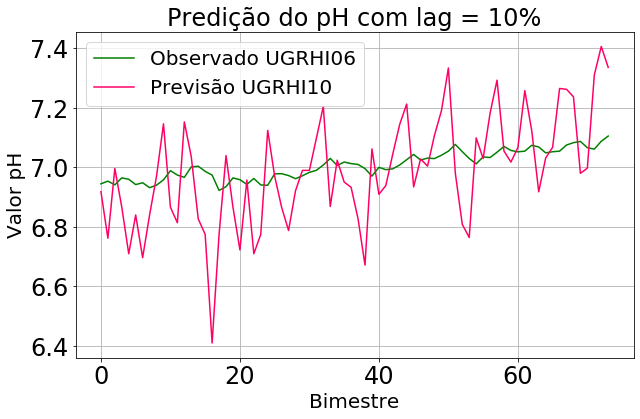

In [94]:
test06 = sc.inverse_transform(test06)

#Plotagem do gráfico
plt.plot(y_pred10, color = 'green', label = 'Observado UGRHI06')
plt.plot(test06, color = '#ff0066', label = 'Previsão UGRHI10')
plt.title('Predição do pH com lag = 10%')
plt.xlabel('Bimestre')
plt.ylabel('Valor pH')
plt.legend()
plt.grid()
plt.show()

In [95]:
def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore


In [96]:
print('Resultados com lag', lags)
print('\n')
print('MAPE TREINO:',round(mape(y_pred10t,treino)[0],2),'%')
print('RMSE TREINO:',round(rmse(y_pred10t,treino),2))
print('R TREINO:',round(r2(y_pred10t,treino),2))
print('\n')
print('MAPE TESTE:',round(mape(y_pred10,test06)[0],2),'%')
print('RMSE TESTE:',round(rmse(y_pred10,test06),2))
print('R TESTE:',round(r2(y_pred10,test06),2))
print('\n')




Resultados com lag 87


MAPE TREINO: 1.26 %
RMSE TREINO: 0.13
R TREINO: -0.01


MAPE TESTE: 1.41 %
RMSE TESTE: 0.17
R TESTE: 0.2




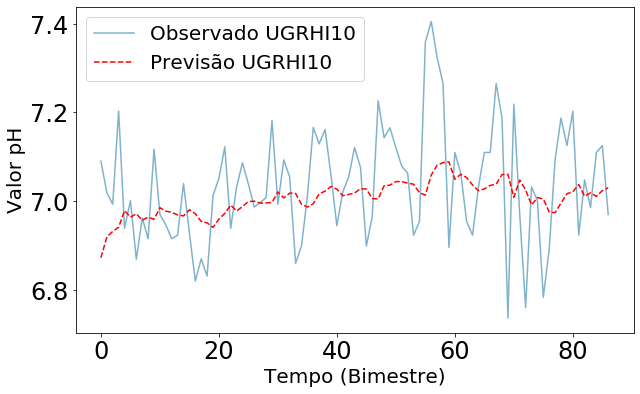

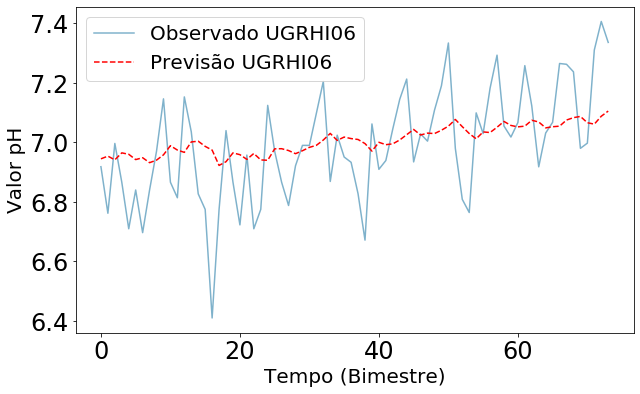

In [97]:
#train_y = train_y.reshape(-1, 1)
#observado_treino = sc.inverse_transform(train_y)

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(treino, color = '#006699', alpha=0.5, label = 'Observado UGRHI10')
plt.plot(y_pred10t, color = 'red',linestyle = '--', label = 'Previsão UGRHI10')
#plt.title('Predição do pH com lag = 10%')
plt.xlabel('Tempo (Bimestre)')
plt.ylabel('Valor pH')
plt.legend()
#plt.grid()
plt.show()

observado_test = test06

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(observado_test, color = '#006699', alpha=0.5, label = 'Observado UGRHI06')
plt.plot(y_pred10, color = 'red',linestyle = '--', label = 'Previsão UGRHI06')
#plt.title('Predição do pH com lag = 10%')
plt.xlabel('Tempo (Bimestre)')
plt.ylabel('Valor pH')
plt.legend()
#plt.grid()
plt.show()